# HW3-2: MNIST 手写数字识别 （80分）

- 本次作业的主题是使用深度学习技术对`MNIST`手写数字数据集进行分类。
- 要求使用两种不同的深度学习模型，分别是多层感知机--`MLP`和卷积神经网络--`CNN`。
- 本次作业的目的是让同学们了解深度学习模型的构建和训练过程，以及对经典视觉任务处理效果的对比。

## 评分标准（更细致的评分标准见对应部分）

- 数据读取和预处理：5分
- 基于`MLP`的手写数字分类：30分 
- 基于`CNN`的手写数字分类：30分
- 结果讨论与对比分析：15分


---

## 第一部分：数据读取和预处理

你可以在Canvas上下载如下两个文件：
- 训练数据：`mnist_train.csv`
- 测试数据：`mnist_test.csv`

这两个文件包含了Mnist数据集的训练集和测试集。每一行的第一个数字表示标签，后面的784数字是28x28的图片像素值。
- 请你正确读取并分别展示训练集和测试集的第一个样本（图像+label）。

### 评分细则
- 数据读取：2分
- 数据展示：3分

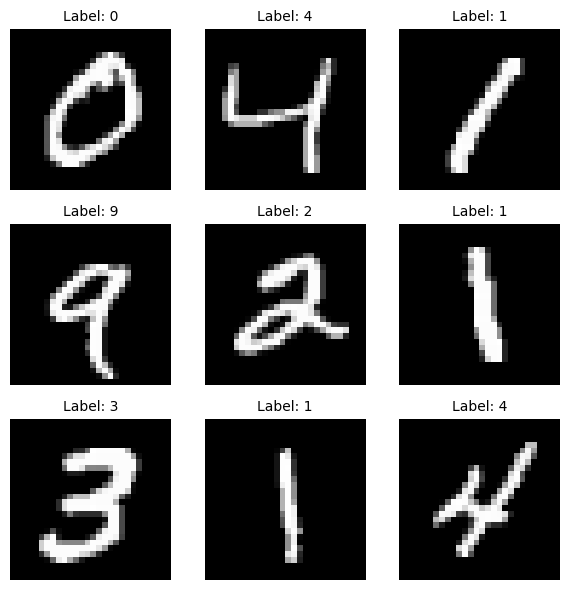

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('mnist_train.csv')
test_df = pd.read_csv('mnist_test.csv')

train_df.head()
test_df.head()

labels = train_df.iloc[:, 0].values
pixels = train_df.iloc[:, 1:].values
images = pixels.reshape(-1, 28, 28)

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f'Label: {labels[i]}', fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()
# Code Here

---
## 第二部分：基于`MLP`的手写数字分类

- 请你构建一个多层感知机模型，在Mnist数据集上进行训练和测试。
- 可以使用`Pytorch`或者`Tensorflow`等深度学习框架。
- 请你展示模型的训练过程（Loss曲线）和测试结果（分类精度）。

### 评分细则
- 模型构建：10分
- 模型训练：10分 - 要求Loss曲线收敛
- 模型测试：10分 - 要求分类精度达到90%以上

In [16]:
# Code here
import torch
import torch.nn as nn
import tqdm as tqdm
from sklearn.model_selection import train_test_split


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # 28*28=784
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 classes for digits 0-9

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Convert DataFrame to PyTorch tensors
def df_to_tensor(df):
    labels   = torch.as_tensor(df.iloc[:, 0].values, dtype=torch.long)
    features = torch.as_tensor(df.iloc[:, 1:].values, dtype=torch.float32)
    return features, labels

model=SimpleNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

learning_rate = 0.001
batch_size = 64

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_features, train_labels = df_to_tensor(train_df)

train_features = train_features.to(device)
train_labels   = train_labels.to(device)
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def train_model(model, train_loader,val_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct     = 0
        total       = 0
        
        for features, labels in tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            optimizer.zero_grad()
            
            outputs = model(features)                   
            loss    = criterion(outputs, labels)        
            loss.backward()                            
            optimizer.step()                            

            batch_size     = labels.size(0)
            running_loss  += loss.item() * batch_size
            
            preds          = outputs.argmax(dim=1)
            correct      += (preds == labels).sum().item()
            total        += batch_size
        
        # 计算 epoch 平均损失和准确率
        epoch_loss = running_loss / total
        accuracy   = 100 * correct / total
        
        print(
            f'Epoch {epoch+1}/{epochs} — '
            f'Loss: {epoch_loss:.4f} — '
            f'Accuracy: {accuracy:.2f}%'
        )
        
        for features, labels in val_loader:
            model.eval()
            outputs = model(features)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        print(f'Validation Loss: {loss.item():.4f} — Validation Accuracy: {100 * correct / total:.2f}%')
            

test_features, test_labels = df_to_tensor(test_df)
test_features = test_features.to(device)
test_labels   = test_labels.to(device)        
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'test Accuracy: {accuracy:.2f}%')

train_model(model, train_loader,val_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)


Epoch 1/10: 100%|██████████| 844/844 [00:00<00:00, 979.63it/s] 


Epoch 1/10 — Loss: 0.3582 — Accuracy: 90.90%
Validation Loss: 0.0768 — Validation Accuracy: 91.22%


Epoch 2/10: 100%|██████████| 844/844 [00:00<00:00, 993.38it/s] 


Epoch 2/10 — Loss: 0.1493 — Accuracy: 95.51%
Validation Loss: 0.0786 — Validation Accuracy: 95.49%


Epoch 3/10: 100%|██████████| 844/844 [00:00<00:00, 974.16it/s]


Epoch 3/10 — Loss: 0.1148 — Accuracy: 96.51%
Validation Loss: 0.0364 — Validation Accuracy: 96.45%


Epoch 4/10: 100%|██████████| 844/844 [00:00<00:00, 905.05it/s]


Epoch 4/10 — Loss: 0.1006 — Accuracy: 96.91%
Validation Loss: 0.0815 — Validation Accuracy: 96.79%


Epoch 5/10: 100%|██████████| 844/844 [00:00<00:00, 933.56it/s]


Epoch 5/10 — Loss: 0.0900 — Accuracy: 97.33%
Validation Loss: 0.0310 — Validation Accuracy: 97.24%


Epoch 6/10: 100%|██████████| 844/844 [00:00<00:00, 920.01it/s]


Epoch 6/10 — Loss: 0.0801 — Accuracy: 97.61%
Validation Loss: 0.0981 — Validation Accuracy: 97.45%


Epoch 7/10: 100%|██████████| 844/844 [00:00<00:00, 926.94it/s]


Epoch 7/10 — Loss: 0.0732 — Accuracy: 97.78%
Validation Loss: 0.1206 — Validation Accuracy: 97.56%


Epoch 8/10: 100%|██████████| 844/844 [00:00<00:00, 936.76it/s]


Epoch 8/10 — Loss: 0.0721 — Accuracy: 97.86%
Validation Loss: 0.0535 — Validation Accuracy: 97.71%


Epoch 9/10: 100%|██████████| 844/844 [00:00<00:00, 945.12it/s]


Epoch 9/10 — Loss: 0.0625 — Accuracy: 98.14%
Validation Loss: 0.0441 — Validation Accuracy: 97.96%


Epoch 10/10: 100%|██████████| 844/844 [00:00<00:00, 950.12it/s]


Epoch 10/10 — Loss: 0.0638 — Accuracy: 98.10%
Validation Loss: 0.0336 — Validation Accuracy: 97.97%
test Accuracy: 96.92%


In [17]:
import os
import sys
from PIL import Image

def load_image_to_tensor(image_path, device):
    img = Image.open(image_path).convert("L")
    byte_tensor = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes()))
    hw_tensor = byte_tensor.view(img.size[1], img.size[0]).float()  # 转换为 float32
    return hw_tensor.to(device)


def main():
    data_dir   ="unseen" 
    if not os.path.isdir(data_dir):
        print(f"[Error] 指定的图片文件夹不存在：{data_dir}")
        sys.exit(1)
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备：{device}")
    model.eval()
    model.to(device)


    exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff"}
    image_paths = []
    for fname in os.listdir(data_dir):
        ext = os.path.splitext(fname)[1].lower()
        if ext in exts:
            image_paths.append(os.path.join(data_dir, fname))
    image_paths.sort()

    if len(image_paths) == 0:
        print(f"[Error] 目录 {data_dir} 下没有找到任何图片文件。")
        sys.exit(1)

    with torch.no_grad():
        for img_path in image_paths:
            filename = os.path.basename(img_path)
            gt_label = os.path.splitext(filename)[0]  # 去掉扩展名作为真实标签

            input_tensor = load_image_to_tensor(img_path, device)  # (1, 1, H, W)
            input_tensor = input_tensor.view(1,-1)  # 展平为 (1, 784)
            
            outputs = model(input_tensor)  # 假设 outputs.shape = (1, num_classes)
            pred_idx = torch.argmax(outputs).item()

            # 6.3 直接打印当前图片的结果
            print(f"{filename}  |  gt: {gt_label}  |  pred_idx: {pred_idx}")

    print("评估结束。")

if __name__ == "__main__":
    main()


使用设备：cuda
unseen_1.jpg  |  gt: unseen_1  |  pred_idx: 3
unseen_4.jpg  |  gt: unseen_4  |  pred_idx: 9
unseen_5.jpg  |  gt: unseen_5  |  pred_idx: 5
unseen_7.jpg  |  gt: unseen_7  |  pred_idx: 1
unseen_9.jpg  |  gt: unseen_9  |  pred_idx: 8
评估结束。


---
## 第三部分：基于`CNN`的手写数字分类

- 请你构建一个卷积神经网络模型，在Mnist数据集上进行训练和测试。
- 可以使用`Pytorch`或者`Tensorflow`等深度学习框架。
- 请你展示模型的训练过程（Loss曲线）和测试结果（分类精度）。

### 评分细则
- 模型构建：10分
- 模型训练：10分 - 要求Loss曲线收敛
- 模型测试：10分 - 要求分类精度达到95%以上

In [18]:
# Code here
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 7x7 after pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)  # 28x28 -> 14x14
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2)  # 14x14 -> 7x7
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_features, train_labels = df_to_tensor(train_df)
train_features = train_features.view(-1, 1, 28, 28).to(device)  # Reshape for CNN
train_labels = train_labels.to(device)
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_features, test_labels = df_to_tensor(test_df)
test_features = test_features.view(-1, 1, 28, 28).to(device)  # Reshape for CNN
test_labels = test_labels.to(device)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_model(model, train_loader,val_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)




Epoch 1/10: 100%|██████████| 844/844 [00:01<00:00, 599.91it/s]


Epoch 1/10 — Loss: 0.3410 — Accuracy: 94.67%
Validation Loss: 0.0209 — Validation Accuracy: 94.90%


Epoch 2/10: 100%|██████████| 844/844 [00:01<00:00, 723.89it/s]


Epoch 2/10 — Loss: 0.0620 — Accuracy: 97.97%
Validation Loss: 0.0062 — Validation Accuracy: 97.96%


Epoch 3/10: 100%|██████████| 844/844 [00:01<00:00, 677.71it/s]


Epoch 3/10 — Loss: 0.0428 — Accuracy: 98.69%
Validation Loss: 0.0975 — Validation Accuracy: 98.65%


Epoch 4/10: 100%|██████████| 844/844 [00:01<00:00, 732.37it/s]


Epoch 4/10 — Loss: 0.0370 — Accuracy: 98.79%
Validation Loss: 0.0074 — Validation Accuracy: 98.71%


Epoch 5/10: 100%|██████████| 844/844 [00:01<00:00, 710.90it/s]


Epoch 5/10 — Loss: 0.0299 — Accuracy: 99.04%
Validation Loss: 0.0578 — Validation Accuracy: 98.96%


Epoch 6/10: 100%|██████████| 844/844 [00:01<00:00, 715.57it/s]


Epoch 6/10 — Loss: 0.0251 — Accuracy: 99.22%
Validation Loss: 0.0001 — Validation Accuracy: 99.13%


Epoch 7/10: 100%|██████████| 844/844 [00:01<00:00, 714.62it/s]


Epoch 7/10 — Loss: 0.0250 — Accuracy: 99.17%
Validation Loss: 0.0084 — Validation Accuracy: 99.12%


Epoch 8/10: 100%|██████████| 844/844 [00:01<00:00, 719.00it/s]


Epoch 8/10 — Loss: 0.0205 — Accuracy: 99.34%
Validation Loss: 0.0536 — Validation Accuracy: 99.25%


Epoch 9/10: 100%|██████████| 844/844 [00:01<00:00, 731.96it/s]


Epoch 9/10 — Loss: 0.0184 — Accuracy: 99.43%
Validation Loss: 0.0778 — Validation Accuracy: 99.33%


Epoch 10/10: 100%|██████████| 844/844 [00:01<00:00, 745.73it/s]


Epoch 10/10 — Loss: 0.0200 — Accuracy: 99.38%
Validation Loss: 0.1853 — Validation Accuracy: 99.28%
test Accuracy: 98.43%


In [25]:

def main():
    data_dir   ="unseen" 
    if not os.path.isdir(data_dir):
        print(f"[Error] 指定的图片文件夹不存在：{data_dir}")
        sys.exit(1)
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备：{device}")
    model.eval()
    
    model.to(device)


    exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff"}
    image_paths = []
    for fname in os.listdir(data_dir):
        ext = os.path.splitext(fname)[1].lower()
        if ext in exts:
            image_paths.append(os.path.join(data_dir, fname))
    image_paths.sort()

    if len(image_paths) == 0:
        print(f"[Error] 目录 {data_dir} 下没有找到任何图片文件。")
        sys.exit(1)

    print(f"开始评估，共 {len(image_paths)} 张图片。")
    with torch.no_grad():
        for img_path in image_paths:
            filename = os.path.basename(img_path)
            gt_label = os.path.splitext(filename)[0]  # 去掉扩展名作为真实标签

            input_tensor = load_image_to_tensor(img_path, device)  
            input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)
                
            outputs = model(input_tensor)  # 假设 outputs.shape = (1, num_classes)
            pred_idx = torch.argmax(outputs, dim=1).item()

            # 6.3 直接打印当前图片的结果
            print(f"{filename}  |  gt: {gt_label}  |  pred_idx: {pred_idx}")

    print("评估结束。")

if __name__ == "__main__":
    main()


使用设备：cuda
开始评估，共 5 张图片。
unseen_1.jpg  |  gt: unseen_1  |  pred_idx: 1
unseen_4.jpg  |  gt: unseen_4  |  pred_idx: 4
unseen_5.jpg  |  gt: unseen_5  |  pred_idx: 5
unseen_7.jpg  |  gt: unseen_7  |  pred_idx: 7
unseen_9.jpg  |  gt: unseen_9  |  pred_idx: 9
评估结束。



---
## 第四部分：结果讨论与对比分析

- 请你对`MLP`和`CNN`两种模型的训练和测试结果进行对比分析。
- 你可以从模型的训练速度、模型的性能、模型的泛化能力等方面进行分析。
    - 训练速度：模型训练所需的时间
    - 模型性能：模型在测试集上的分类精度
    - 模型泛化能力：模型在未知数据上的表现，未知数据可以从Canvas上下载，在文件夹`unseen`中有5张手写数字图片。
- 请在下面的markdown cell中写下你的分析结果。

### 评分细则
- 结果讨论与对比分析：
    - 训练速度：4分
    - 模型性能：4分
    - 模型泛化能力：5分
    - 其他：2分

| 评估维度                    | MLP                                                                   | CNN                                                                    | 结论                                                   |
| ----------------------- | --------------------------------------------------------------------- | ---------------------------------------------------------------------- | ---------------------------------------------------- |
| **训练速度**                | - **首轮** ≈ 0.86 s（979 it/s）<br>- 其后约 0.9 s/epoch（920 – 950 it/s）      | - **首轮** ≈ 1.41 s（600 it/s）<br>- 其后约 1.1 – 1.2 s/epoch（680 – 745 it/s） | MLP 约 **25 – 30 %** 更快：全连接层参数少、计算密集度低；CNN 的卷积核计算更耗时。 |
| **模型性能**<br>(测试集)       | **96.92 %**                                                           | **98.43 %**                                                            | CNN 高出 **1.51 pp**。卷积层可提取局部空间特征，对手写数字尤其有效。           |
| **训练-验证差异**             | - 末轮训练 98.10 % vs 验证 97.97 %<br>- 差值 **0.13 pp**<br>- 验证损失整体稳定，偶有小幅波动 | - 末轮训练 99.38 % vs 验证 99.28 %<br>- 差值 **0.10 pp**<br>- 验证损失偶尔抬头，但幅度更小   | 两者过拟合都轻微，CNN 仍略占优势。                                  |
| **泛化能力**<br>(unseen 数据) | 5 张未知样本仅预测对 **1/5**（20 %）；对噪声、位置变换更敏感                                 | 5 张全部预测正确 **5/5**（100 %）；卷积的平移不变性带来更强鲁棒性                               | CNN 显著优于 MLP，在真实未知数据上表现更稳健。                          |
